# Semiconductor Wafer Pass/Fail Prediction

**Author:** Vaibhav Sharma  
**Institution:** IIT Hyderabad (MTech, Semiconductor Materials & Devices)  
**Focus:** Machine Learning for Semiconductor Yield Optimization  

# Table of Contents

1. **Data Cleaning & Visualization**
   - Handling missing values  
   - Correlation analysis  
   - Outlier detection (box plots, distributions)  

2. **Feature Engineering & Multicollinearity**
   - Removing features with correlation > 0.95  
   - Discussion of Variance Inflation Factor (VIF)  

3. **Train-Test Split & Scaling**
   - Splitting data into training and test sets  
   - Standardizing features  

4. **Handling Class Imbalance**
   - SMOTE (Synthetic Minority Oversampling Technique)  
   - ADASYN (Adaptive Synthetic Sampling)  

5. **Model Training**
   - Logistic Regression (baseline + tuned)  
   - Decision Tree  
   - XGBoost (baseline + tuned)  
   - Dummy Classifier (baseline)  

6. **Hyperparameter Tuning**
   - GridSearchCV for Logistic Regression and XGBoost  
   - Evaluation using Average Precision  

7. **Threshold Optimization**
   - Precision-Recall curve analysis  
   - F2-score threshold tuning  

8. **Model Comparison**
   - Results summary table (CSV)  
   - Performance visualization  

9. **Explainability**
   - Logistic Regression coefficients  
   - SHAP global summary plot  
   - SHAP local waterfall plot  

10. **Deployment-Readiness**
    - `predict_new()` function  
    - Single wafer predictions  

11. **Final Conclusion**
    - Key results  
    - Best models  
    - Explainability  
    


# DATA CLEANING

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
df=pd.read_csv('signal-data.csv')

In [2]:
print('shape of dataframe is',df.shape)

print(df.info())

shape of dataframe is (1567, 592)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB
None


Observations From the Preleminary EDA: #Dataset size: (1567, 592)

#1567 rows → number of samples/process steps.

#592 columns → 591 features + 1 target (Pass/Fail).

#Data types are likely numerical (int, float) for features and maybe object or category for the target.

Number of wafers passed or failed are as follows Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64


<Axes: xlabel='Pass/Fail', ylabel='count'>

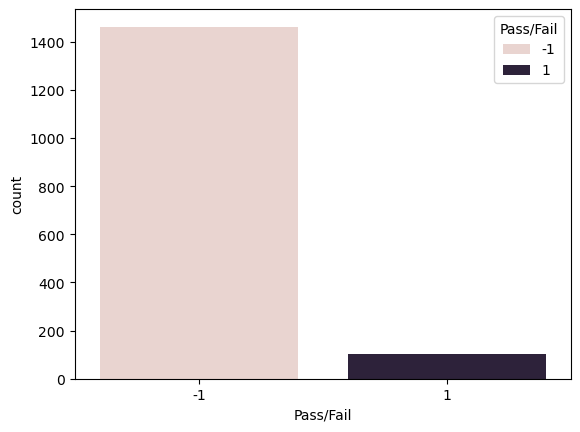

In [3]:
target=df['Pass/Fail']
print('Number of wafers passed or failed are as follows',target.value_counts())
#Lets Visualise it 
import seaborn as sns
sns.countplot(data=df,x=target,hue=target)

###### Observation
We can see that the target value is skewed twards -1 ie Pass.
around 93.4% wafers passed
Thus we have to test our models not just on accuracy but other metrices like Precision,recall,F1 score etc

In [4]:
missing_counts=df.isna().sum()
missing_counts=missing_counts[missing_counts>0] # only viewing columns which have more than 0 missing values
mc=missing_counts.sort_values(ascending=False) #to see columns having max no of missing values

Some Columns have a lot of missing values so we have to drop them,rest we can impute.
We will set up a threshold value ie above that percentage of missing data,we will drop the cell

In [5]:
threshold=0.6
columns_to_drop=mc[mc/len(mc)>threshold].index #gives the indics of columns who have more than 60% missing values
#df.drop(columns_to_drop,inplace=True,axis=1)  
print('Columns dropped',columns_to_drop)
print('Shape of DataFrame after Dropping columns',df.shape)
#also we dont need time feature so lets drop that too
df.drop('Time',axis=1,inplace=True)

Columns dropped Index(['292', '157', '158', '293', '492', '220', '358', '85', '516', '517',
       '382', '111', '383', '384', '246', '244', '245', '110', '518', '109',
       '579', '581', '578', '580', '346', '72', '73', '345', '247', '385',
       '112', '519'],
      dtype='object')
Shape of DataFrame after Dropping columns (1567, 592)


Lets Handle missing values for other columns

In [8]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes!='O']
cat_features=[feature for feature in df.columns if df[feature].dtypes=='O']
print('number of numerical features',len(numerical_features))
print('number of categorical features',len(cat_features))


number of numerical features 591
number of categorical features 0


In [9]:
df=df.fillna(df[numerical_features].mean())

##### Visualise the class imbalence

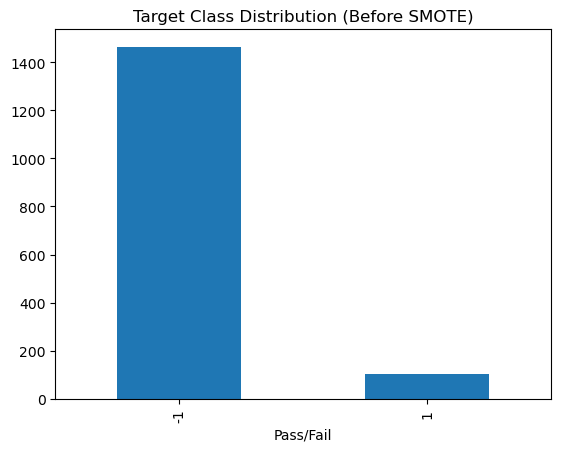

In [10]:
df['Pass/Fail'].value_counts().plot(kind='bar')
plt.title("Target Class Distribution (Before SMOTE)")
plt.show()


#### Skewness & Variance Analysis
Skewness tells us how asymmetric a distribution is.

#0 → symmetric (like normal distribution)

#>0 → right-skewed (tail on right)

#<0 → left-skewed (tail on left)

In [11]:
#Lets find out top 20 most skewed features
skewed_features = df[numerical_features].skew().sort_values(ascending=False)
print("Top 20 most right-skewed features:\n", skewed_features.head(20))
print("\nTop 20 most left-skewed features:\n", skewed_features.tail(20))
#Similarly we can find out top 20 features with highest varience
variance = df[numerical_features].var().sort_values(ascending=False)
print("Top 20 highest variance features:\n", variance.head(20))

Top 20 most right-skewed features:
 209    39.585205
74     39.585205
478    39.585205
342    39.585205
347    39.585205
206    39.585205
390    39.562779
252    39.560364
287    39.559150
152    39.557423
516    39.499588
382    39.491841
244    39.491102
524    38.854591
518    38.711072
384    38.649705
283    38.647193
246    38.563405
148    38.562024
117    38.005963
dtype: float64

Top 20 most left-skewed features:
 20     -2.805058
56     -2.845635
68     -2.902413
104    -3.109224
116    -3.285151
128    -5.379193
54     -5.382071
119    -5.382909
26     -6.019993
36     -6.417518
87     -6.450729
53     -7.218651
570    -8.658927
72     -9.774366
19     -9.862255
11    -10.221613
112   -12.097650
7     -12.951734
17    -22.191121
109   -34.955356
dtype: float64
Top 20 highest variance features:
 162    4.289442e+07
161    1.794825e+07
297    1.039974e+07
24     8.414849e+06
296    3.896083e+06
23     1.902415e+06
159    9.651394e+05
21     3.924042e+05
160    3.299829e+05
204

In [13]:
df['Pass/Fail']=df['Pass/Fail'].map({-1:0,1:1})

In [14]:
df.to_csv("cleaned_data.csv", index=False)